In [1]:
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.table import Table, vstack, hstack, unique,join
import matplotlib.pyplot as plt
import pandas as pd
import sys

# sys.path.append("/global/u2/b/bid13/VI/prospect/py")

import desispec.coaddition
import desispec.io
import desispec.spectra
# from desitarget.cmx.cmx_targetmask import cmx_mask
from desitarget.sv1.sv1_targetmask import desi_mask
from prospect import utilities,plotframes, myspecselect, myspecupdate
from desispec.coaddition import coadd_cameras
from prospect import utilities ,plotframes
# from prospect_my import plotframes

from stack_spectra import _common_grid

In [2]:
my_path = Path("/global/cscratch1/sd/bid13/stack-spectra")

In [131]:
spec = desispec.io.read_spectra(my_path /  "spectra_bright.fits")#coadd_cam_bright.fits")
zcat = Table.read(my_path / "zcat_bright.fits")
flux = spec.flux['r']
wl = spec.wave['r']
ivar = spec.ivar['r']

INFO:spectra.py:253:read_spectra: iotime 0.128 sec to read spectra_bright.fits at 2021-04-07T18:10:16.565484


In [104]:
print(np.shape(flux),np.shape(ivar),np.shape(zcat['Z']))

(16, 2326) (16, 2326) (16,)


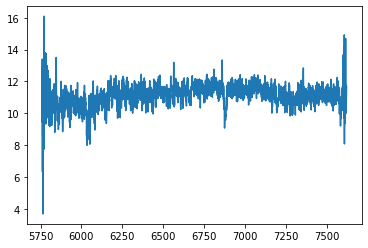

In [105]:
plt.plot(wl,flux[1])

In [106]:
def normalize(flux,ivar):
    norm = np.nanmedian(flux,axis=1).reshape(np.shape(flux)[0],1)
    flux = flux/norm
    ivar = ivar*norm**2
    
    return ivar, flux

In [107]:
def wavg(flux,var=None,weighted=False):
    if weighted:
        num = np.nansum(flux*ivar,axis=0)
        denom = np.nansum(ivar,axis=0)
    
        if 0. in denom:
            denom[denom==0.0] = np.nan
    
        avg = np.nan_to_num(num/denom)
    else:
        avg = np.mean(flux,axis=0)
    return(avg)

In [108]:
new_f,new_i,new_wl = _common_grid(flux, wl, ivar, zcat['Z'], z_out=0.0, wave_grid=None)

In [109]:
i,f = normalize(new_f,new_i)

In [201]:
wavg_f = wavg(f)

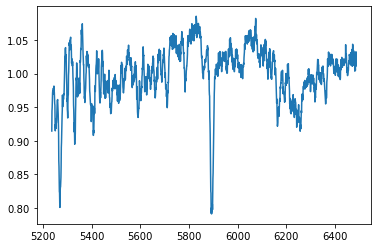

In [202]:
plt.plot(new_wl,wavg_f)

In [112]:
## Bootstrap

In [193]:
ndata = np.shape(new_f)[0]
len_spec = np.shape(new_f)[1]
nbootstraps=int(1E2)
boot = np.zeros((nbootstraps,len_spec))

In [194]:
def _bootstrap(flux_spec,ndata,nbootstraps,len_spec):
    
    boot = np.zeros((nbootstraps,len_spec))
    for i in range(nbootstraps):
        idx=np.random.choice(ndata,1,replace=True)
        boot[i]+=flux_spec[idx][0]
    
    return boot

In [205]:
boot_res = _bootstrap(f,ndata,nbootstraps,len_spec)

In [206]:
boot_avg = wavg(boot_res)

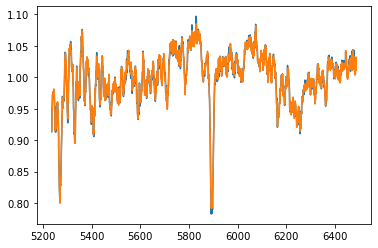

In [208]:
plt.plot(new_wl,boot_avg)
plt.plot(new_wl,wavg_f)